In [1]:
import pandas as pd

# 1️⃣ Load the cleaned AIS dataset
df = pd.read_csv('final/cleaned_AIS_data.csv')



C:\Users\joyji\AppData\Local\Temp\ipykernel_6124\3988624101.py:4: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('final/cleaned_AIS_data.csv')


📉 Downsampled dataset size (1-minute interval): 2101450 entries


In [6]:
# 2️⃣ Ensure 'BaseDateTime' is in datetime format
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])

# 3️⃣ Downsample to 1-minute intervals
vessel_tracks_downsampled = df.groupby(
    ['MMSI', pd.Grouper(key='BaseDateTime', freq='2min')]
).agg({
    'LAT': 'mean',
    'LON': 'mean',
    'SOG': 'mean',
    'COG': 'mean',
    'Heading': 'mean',
    'VesselGroup': 'first'  # Retain vessel group for analysis
}).reset_index()

print(f"📉 Downsampled dataset size (1-minute interval): {len(vessel_tracks_downsampled)} entries")


📉 Downsampled dataset size (1-minute interval): 1651727 entries


In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# 1️⃣ Load the cleaned AIS dataset
df = pd.read_csv('final/cleaned_AIS_data.csv', low_memory=False)

# 2️⃣ Ensure 'BaseDateTime' is in datetime format
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])

# 3️⃣ Filter data for September 2022
sept_2022_data = df[(df['BaseDateTime'].dt.year == 2022) & (df['BaseDateTime'].dt.month == 8)]
print(f"📊 Data points in September 2022: {len(sept_2022_data)}")

# 4️⃣ Downsample: Aggregate every 1 minute to reduce redundancy
sept_2022_downsampled = sept_2022_data.groupby(
    ['MMSI', pd.Grouper(key='BaseDateTime', freq='2min')]
).agg({
    'LAT': 'mean',
    'LON': 'mean',
    'SOG': 'mean',
    'COG': 'mean',
    'Heading': 'mean',
    'VesselGroup': 'first'
}).reset_index()

print(f"📉 Downsampled dataset size (2-minute interval): {len(sept_2022_downsampled)}")




📊 Data points in September 2022: 151750
📉 Downsampled dataset size (2-minute interval): 117659


In [8]:

# 5️⃣ Initialize DBSCAN
dbscan = DBSCAN(eps=0.861, min_samples=10)

# 6️⃣ Apply DBSCAN
clustered_results = []

# Apply DBSCAN for each vessel
for vessel in sept_2022_downsampled['MMSI'].unique():
    vessel_data = sept_2022_downsampled[sept_2022_downsampled['MMSI'] == vessel].copy()
    
    # Select relevant features
    features = vessel_data[['LAT', 'LON', 'SOG', 'COG', 'Heading']]
    
    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Apply DBSCAN
    clusters = dbscan.fit_predict(scaled_features)
    
    # Store cluster labels
    vessel_data['Cluster'] = clusters
    
    clustered_results.append(vessel_data)

# 7️⃣ Combine results into a single DataFrame
sept_2022_clustered = pd.concat(clustered_results)

# 8️⃣ Extract anomalies (-1 indicates anomalies)
sept_2022_anomalies = sept_2022_clustered[sept_2022_clustered['Cluster'] == -1]

print(f"🚨 Total anomalies detected in September 2022: {len(sept_2022_anomalies)}")


🚨 Total anomalies detected in September 2022: 5479


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd

# 1️⃣ Load the cleaned AIS dataset
df = pd.read_csv('final/cleaned_AIS_data.csv', low_memory=False)

# 2️⃣ Ensure 'BaseDateTime' is in datetime format
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])

# 3️⃣ Filter data for September 2022
sept_2022_data = df[(df['BaseDateTime'].dt.year == 2022) & (df['BaseDateTime'].dt.month == 8)]
print(f"📊 Data points in August 2022: {len(sept_2022_data)}")

# 4️⃣ Downsample to 2-minute intervals using MEDIAN
vessel_tracks_downsampled1 = sept_2022_data.groupby(
    ['MMSI', pd.Grouper(key='BaseDateTime', freq='min')]
).agg({
    'LAT': 'median',
    'LON': 'median',
    'SOG': 'median',
    'COG': 'median',
    'Heading': 'median',
    'VesselGroup': 'first'  # Keep the first occurrence of VesselGroup
}).reset_index()

print(f"📉 Downsampled dataset size (2-minute interval with median): {len(vessel_tracks_downsampled1)}")

# 5️⃣ Initialize DBSCAN
dbscan = DBSCAN(eps=0.861, min_samples=10)

# 6️⃣ Define the vessel groups to analyze
target_vessel_groups = ['Cargo', 'Fishing', 'Tanker', 'Pleasure Craft/Sailing']

# 7️⃣ Dictionaries to store results
anomalies_by_group = {}
total_entries_by_group = {}
clustered_results_all_groups = []

# 8️⃣ Apply DBSCAN for each VesselGroup
for group in target_vessel_groups:
    print(f"🔍 Processing Vessel Group: {group}")
    
    # Filter data for the current VesselGroup
    group_data = vessel_tracks_downsampled1[vessel_tracks_downsampled1['VesselGroup'] == group]
    
    # Store total data points for the group
    total_entries_by_group[group] = len(group_data)
    
    clustered_results = []
    
    # Apply DBSCAN on each vessel within the group
    for vessel in group_data['MMSI'].unique():
        vessel_data = group_data[group_data['MMSI'] == vessel].copy()
        
        # Select relevant features
        features = vessel_data[['LAT', 'LON', 'SOG', 'COG', 'Heading']]
        
        # Scale the data
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        # Apply DBSCAN
        clusters = dbscan.fit_predict(scaled_features)
        
        # ✅ Store cluster labels
        vessel_data['Cluster'] = clusters
        
        # Collect vessel data with cluster labels
        clustered_results.append(vessel_data)
    
    # ✅ Combine results for the current group
    group_clustered_data = pd.concat(clustered_results)
    
    # ✅ Append to all groups' results
    clustered_results_all_groups.append(group_clustered_data)
    
    # ✅ Collect anomalies (-1 indicates anomaly)
    group_anomalies = group_clustered_data[group_clustered_data['Cluster'] == -1]
    
    # ✅ Store anomalies for the current group
    anomalies_by_group[group] = group_anomalies
    
    # ✅ Print summary for the group
    anomaly_count = len(group_anomalies)
    total_count = total_entries_by_group[group]
    anomaly_percentage = (anomaly_count / total_count) * 100
    
    print(f"📊 Total data points in {group}: {total_count}")
    print(f"🚨 Anomalies detected in {group}: {anomaly_count}")
    print(f"📈 Anomaly Percentage in {group}: {anomaly_percentage:.2f}%\n")

# 9️⃣ ✅ Properly update vessel_tracks_downsampled1 with 'Cluster' column
vessel_tracks_downsampled1 = pd.concat(clustered_results_all_groups)

# 🔟 ✅ Combine all anomalies across selected vessel groups
all_group_anomalies = pd.concat(anomalies_by_group.values())

print(f"🚨 Total anomalies detected across all selected vessel groups: {len(all_group_anomalies)}")


📊 Data points in August 2022: 151750
📉 Downsampled dataset size (2-minute interval with median): 151711
🔍 Processing Vessel Group: Cargo
📊 Total data points in Cargo: 48459
🚨 Anomalies detected in Cargo: 1903
📈 Anomaly Percentage in Cargo: 3.93%

🔍 Processing Vessel Group: Fishing
📊 Total data points in Fishing: 46613
🚨 Anomalies detected in Fishing: 454
📈 Anomaly Percentage in Fishing: 0.97%

🔍 Processing Vessel Group: Tanker
📊 Total data points in Tanker: 3303
🚨 Anomalies detected in Tanker: 520
📈 Anomaly Percentage in Tanker: 15.74%

🔍 Processing Vessel Group: Pleasure Craft/Sailing
📊 Total data points in Pleasure Craft/Sailing: 12007
🚨 Anomalies detected in Pleasure Craft/Sailing: 2708
📈 Anomaly Percentage in Pleasure Craft/Sailing: 22.55%

🚨 Total anomalies detected across all selected vessel groups: 5585


🚢 Selected MMSIs for visualization: [212210000 219028012 219469000 232036941 241489000]


C:\Users\joyji\AppData\Local\Temp\ipykernel_6124\1382281465.py:34: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


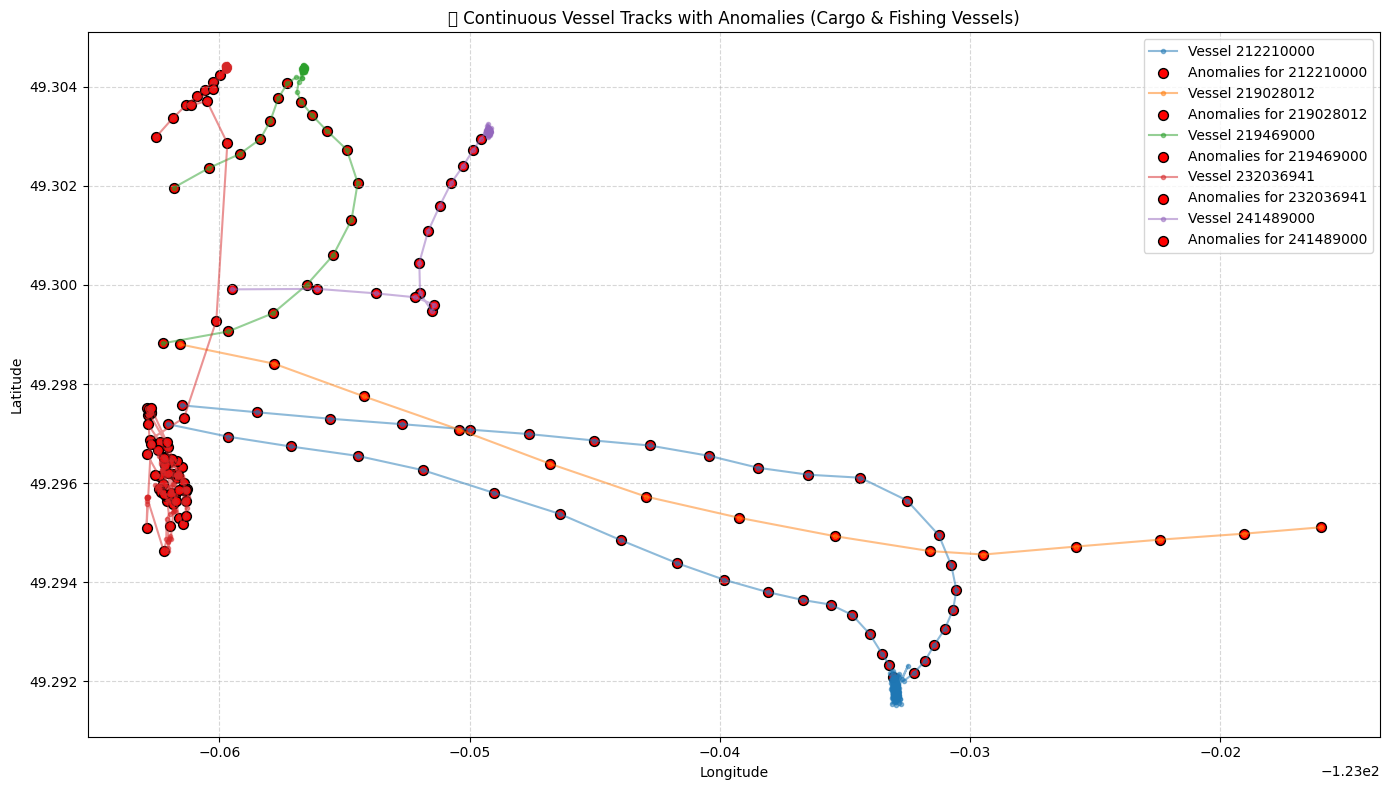

🌍 Interactive map saved as 'cargo_fishing_vessel_anomalies.html'


In [17]:
import matplotlib.pyplot as plt
import folium
import pandas as pd

# 1️⃣ Filter anomalies for Cargo and Fishing vessel groups
cargo_fishing_anomalies = all_group_anomalies[all_group_anomalies['VesselGroup'].isin(['Cargo', 'Fishing'])]

# 2️⃣ Select 5 vessels with detected anomalies
selected_mmsis = cargo_fishing_anomalies['MMSI'].unique()[:5]
print(f"🚢 Selected MMSIs for visualization: {selected_mmsis}")

# 3️⃣ Filter downsampled data for selected vessels
selected_vessel_tracks = vessel_tracks_downsampled1[
    (vessel_tracks_downsampled1['MMSI'].isin(selected_mmsis)) &
    (vessel_tracks_downsampled1['VesselGroup'].isin(['Cargo', 'Fishing']))
]

# 🔵 4️⃣ Plot Continuous Vessel Tracks with Anomalies (Matplotlib)
plt.figure(figsize=(14, 8))

for mmsi in selected_mmsis:
    vessel_data = selected_vessel_tracks[selected_vessel_tracks['MMSI'] == mmsi].sort_values(by='BaseDateTime')
    plt.plot(vessel_data['LON'], vessel_data['LAT'],
             marker='o', markersize=3, linestyle='-', alpha=0.5, label=f'Vessel {mmsi}')
    vessel_anomalies = cargo_fishing_anomalies[cargo_fishing_anomalies['MMSI'] == mmsi]
    plt.scatter(vessel_anomalies['LON'], vessel_anomalies['LAT'],
                color='red', s=50, edgecolor='black', label=f'Anomalies for {mmsi}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('🌊 Continuous Vessel Tracks with Anomalies (Cargo & Fishing Vessels)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 🌍 5️⃣ Plot Vessel Tracks on an Interactive Map (Folium)
mean_lat = selected_vessel_tracks['LAT'].mean()
mean_lon = selected_vessel_tracks['LON'].mean()

base_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=8, tiles='CartoDB positron')

for mmsi in selected_mmsis:
    vessel_data = selected_vessel_tracks[selected_vessel_tracks['MMSI'] == mmsi].sort_values(by='BaseDateTime')
    track_coords = vessel_data[['LAT', 'LON']].values.tolist()
    folium.PolyLine(track_coords, color='blue', weight=2, opacity=0.7, tooltip=f'Vessel {mmsi}').add_to(base_map)
    vessel_anomalies = cargo_fishing_anomalies[cargo_fishing_anomalies['MMSI'] == mmsi]
    for _, anomaly in vessel_anomalies.iterrows():
        folium.CircleMarker(
            location=[anomaly['LAT'], anomaly['LON']],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.9,
            popup=f"Anomaly - MMSI: {anomaly['MMSI']}\nTime: {anomaly['BaseDateTime']}"
        ).add_to(base_map)

# 6️⃣ Save and Display the Interactive Map
base_map.save('cargo_fishing_vessel_anomalies.html')
print("🌍 Interactive map saved as 'cargo_fishing_vessel_anomalies.html'")


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd

# 1️⃣ Load the cleaned AIS dataset
df = pd.read_csv('final/cleaned_AIS_data.csv', low_memory=False)

# 2️⃣ Ensure 'BaseDateTime' is in datetime format
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])


# 4️⃣ Downsample to 2-minute intervals using MEDIAN
vessel_tracks_downsampled1 = df.groupby(
    ['MMSI', pd.Grouper(key='BaseDateTime', freq='min')]
).agg({
    'LAT': 'median',
    'LON': 'median',
    'SOG': 'median',
    'COG': 'median',
    'Heading': 'median',
    'VesselGroup': 'first'  # Keep the first occurrence of VesselGroup
}).reset_index()

print(f"📉 Downsampled dataset size (2-minute interval with median): {len(vessel_tracks_downsampled1)}")

# 5️⃣ Initialize DBSCAN
dbscan = DBSCAN(eps=0.861, min_samples=10)

# 6️⃣ Define the vessel groups to analyze
target_vessel_groups = ['Cargo', 'Fishing', 'Tanker', 'Pleasure Craft/Sailing']

# 7️⃣ Dictionaries to store results
anomalies_by_group = {}
total_entries_by_group = {}
clustered_results_all_groups = []

# 8️⃣ Apply DBSCAN for each VesselGroup
for group in target_vessel_groups:
    print(f"🔍 Processing Vessel Group: {group}")
    
    # Filter data for the current VesselGroup
    group_data = vessel_tracks_downsampled1[vessel_tracks_downsampled1['VesselGroup'] == group]
    
    # Store total data points for the group
    total_entries_by_group[group] = len(group_data)
    
    clustered_results = []
    
    # Apply DBSCAN on each vessel within the group
    for vessel in group_data['MMSI'].unique():
        vessel_data = group_data[group_data['MMSI'] == vessel].copy()
        
        # Select relevant features
        features = vessel_data[['LAT', 'LON', 'SOG', 'COG', 'Heading']]
        
        # Scale the data
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        # Apply DBSCAN
        clusters = dbscan.fit_predict(scaled_features)
        
        # ✅ Store cluster labels
        vessel_data['Cluster'] = clusters
        
        # Collect vessel data with cluster labels
        clustered_results.append(vessel_data)
    
    # ✅ Combine results for the current group
    group_clustered_data = pd.concat(clustered_results)
    
    # ✅ Append to all groups' results
    clustered_results_all_groups.append(group_clustered_data)
    
    # ✅ Collect anomalies (-1 indicates anomaly)
    group_anomalies = group_clustered_data[group_clustered_data['Cluster'] == -1]
    
    # ✅ Store anomalies for the current group
    anomalies_by_group[group] = group_anomalies
    
    # ✅ Print summary for the group
    anomaly_count = len(group_anomalies)
    total_count = total_entries_by_group[group]
    anomaly_percentage = (anomaly_count / total_count) * 100
    
    print(f"📊 Total data points in {group}: {total_count}")
    print(f"🚨 Anomalies detected in {group}: {anomaly_count}")
    print(f"📈 Anomaly Percentage in {group}: {anomaly_percentage:.2f}%\n")

# 9️⃣ ✅ Properly update vessel_tracks_downsampled1 with 'Cluster' column
vessel_tracks_downsampled1 = pd.concat(clustered_results_all_groups)

# 🔟 ✅ Combine all anomalies across selected vessel groups
all_group_anomalies = pd.concat(anomalies_by_group.values())

print(f"🚨 Total anomalies detected across all selected vessel groups: {len(all_group_anomalies)}")
